# GSE104284 - Replicated K27ac K4me1 K4me3 mice injury

Logbook: https://docs.google.com/document/d/1vxU3bRWPjKhz4yto3eOQxKDNQQu0xsyi9IUCSsWBS9k/edit#heading=h.44kd47qfiiva


In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.display import display
import pandas as pd

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import scipy as sp
import os, re
import glob
from tqdm.auto import tqdm
import subprocess, tempfile

import plotly.graph_objects as go
import plotly.express as px

In [2]:
# Here and there < 5mln reads
UNDER_5MLN_TRACKS = [
'GSM2794025_3h_03_Right_B_K27ac_C36PAACXX.8',  
'GSM2794037_3h_11_Right_K27ac_C36PAACXX.8',
'GSM2794038_3h_11_Right_K4me1_C36PAACXX.8',
'GSM2794039_3h_11_Right_K4me3_C36PAACXX.8',
'GSM2794042_3h_11_Left_K4me1_C36PAACXX.8',
'GSM2794044_3h_12_Right_K27ac_C36PAACXX.7',
'GSM2794045_3h_12_Right_K4me1_C36PAACXX.7',
'GSM2794046_3h_12_Right_K4me3_C36PAACXX.7',
'GSM2794047_3h_12_Left_K27ac_C36PAACXX.7',
'GSM2794048_3h_12_Left_K4me1_C36PAACXX.7',
'GSM2794049_3h_12_Left_K4me3_C36PAACXX.7',
'GSM2794072_C4KGFACXX.1.10hr_06_Right_K4me3',
'GSM2794086_C36UVACXX.3.24hr_02_Left_K27ac',
'GSM2794205_C3A8DACXX140504.1.7d_02_Right_K27ac',
'GSM2794214_C3A8DACXX140504.5.7d_03_Right_K4me1',
'GSM2794222_C3A8DACXX140504.7.7d_04_Right_K4me3',
'GSM2794225_C3A8DACXX140504.8.7d_04_Right_K4me3',
'GSM2794235_C3A8DACXX140504.7.7d_04B_Right_K27ac',
'GSM2794239_C3A8DACXX140504.8.7d_04B_Right_K27ac',
'GSM2794244_C3A8DACXX140504.7.7d_04B_Left_K4me1',
'GSM2794245_C3A8DACXX140504.7.7d_04B_Left_K4me3',
'GSM2794248_C3A8DACXX140504.8.7d_04B_Left_K4me1',
'GSM2794249_C3A8DACXX140504.8.7d_04B_Left_K4me3',
'GSM2794280_C4KGFACXX.8.14d_04_Right_K4me1',
'GSM2794288_C4KGFACXX.8.14d_05_Right_K4me3',
]


LOW_QUALITY_MACS2 = [
'GSM2794029_3h_03_Left_K4me3_C36PAACXX.7',
'GSM2794051_C4KGFACXX.2.3hr_015_Right_K4me1',
'GSM2794087_C36UVACXX.3.24hr_02_Left_K4me1',
'GSM2794094_C36UVACXX.4.24hr_03_Left_K4me1',
'GSM2794098_C36UVACXX.5.24hr_03_Left_K4me1',
'GSM2794102_C36UVACXX.2.24hr_04_Right_K4me1',
'GSM2794106_C36UVACXX.4.24hr_04_Left_K4me1',
'GSM2794110_C36UVACXX.5.24hr_04_Left_K4me1',
'GSM2794114_C36UVACXX.6.24hr_05_Left_K4me1',
'GSM2794117_C36UVACXX.7.24hr_05_Left_K4me1',
'GSM2794124_C4KDJACXX.8.48h_01_Left_K27ac',
'GSM2794146_C3CBFACXX.2.48hr_05_Left_K4me1',
'GSM2794148_C4KDJACXX.8.48h_05_Left_K4me1',
'GSM2794151_C3CBFACXX.3.48hr_05_Left_K4me1',
'GSM2794171_C3CBFACXX.4.72hr_02_Left_K4me1',
'GSM2794175_C3CBFACXX.5.72hr_02_Left_K4me1',
'GSM2794187_C3CBFACXX.7.72hr_04_Right_K4me1',
'GSM2794191_C3CBFACXX.7.72hr_04_Left_K4me1',
'GSM2794198_C3CBFACXX.8.72hr_05_Right_K4me1',
'GSM2794236_C3A8DACXX140504.7.7d_04B_Right_K4me1',
'GSM2794240_C3A8DACXX140504.8.7d_04B_Right_K4me1',
'GSM2794244_C3A8DACXX140504.7.7d_04B_Left_K4me1',
'GSM2794248_C3A8DACXX140504.8.7d_04B_Left_K4me1',
'GSM2794255_C3A8DACXX140504.4.7d_05_Left_K27ac',
'GSM2794256_C3A8DACXX140504.4.7d_05_Left_K4me1',
'GSM2794257_C3A8DACXX140504.4.7d_05_Left_K4me3',
'GSM2794268_C3A8DACXX140504.2.14d_02_Right_K4me1',
'GSM2794283_C3A8DACXX140504.6.14d_04_Left_K4me1',
'GSM2794305_C4KDJACXX.6.21d_04_Left_K4me1',
'GSM2794332_C4KGFACXX.6.28d_05_Right_K4me1',
'GSM2794335_C4KGFACXX.6.28d_05_Left_K4me1',
]

def ok(f):
    for bt in UNDER_5MLN_TRACKS + LOW_QUALITY_MACS2:
        if bt in f:
            return False
    return True

# Downloaded GEO peaks

In [3]:
GEO_FOLDER='/mnt/stripe/shpynov/2020_GSE104284_replicated_k27ac_k4me1_k4me3/geo'

dfg = pd.DataFrame(columns=['gsm', 'time', 'direction', 'modification', 'replicate', 
                            'level', 'file', 'peaks', 'length'])
for file in tqdm(glob.glob(GEO_FOLDER + '/*.*')):
    if 'Input' in file or not ok(file):
        continue
    gsm = re.sub('_.*', '', os.path.basename(file))
    time = re.sub(f'(.*Aguilar_)|(_[0-9a-zA-Z]+_.*)', '', os.path.basename(file))
    direction = next((d for d in ['Left', 'Right'] if d in os.path.basename(file)), None)
    modification = next((m for m in ['K4me1', 'K4me3', 'K27ac'] if m in os.path.basename(file)), None)        
    replicate = re.sub(f'(.*{time}_)|(_{direction}.*)', '', os.path.basename(file))
    out = ! awk '{{N+=1;L+=($$3-$$2)}} END{{print(N,L)}}' {file}
    if out[0].strip() != '':
        peaks, length = out[0].split(' ') 
    else:
        peaks, length = 0, 0
    dfg.loc[len(dfg)] = (gsm, time, direction, modification, replicate, 'geo', file, peaks, length)

# display(dfg.head())    
    
dfg['timesrt'] = ["{:0>3d}".format(int(re.match('[0-9]+', t)[0]) * 24) if 
                   t.endswith('d') else "{:0>3d}".format(int(re.match('[0-9]+', t)[0])) 
                  for t in dfg['time'] ]
        
# Fix types
dfg['peaks'] = dfg['peaks'].astype(int)
dfg['length'] = dfg['length'].astype(int)

geo_gsms = set(dfg['gsm'])

In [4]:
dfg['mdt'] = dfg['modification'] + '_' + dfg['direction'] + '_' + dfg['timesrt']
dfg_mean = dfg.groupby(['mdt', 'level'])['peaks'].mean().reset_index().sort_values(by=['mdt', 'level'])
dfg_std = dfg.groupby(['mdt', 'level'])['peaks'].std().reset_index().fillna(0).sort_values(by=['mdt', 'level'])

fig = go.Figure(layout=go.Layout(title=go.layout.Title(text="Peaks")))
for l in sorted(set(dfg_mean['level'])):
    fig.add_trace(go.Scatter(x=dfg_mean.loc[dfg_mean['level']==l]['mdt'], 
                             y=dfg_mean.loc[dfg_mean['level']==l]['peaks'], 
                             name=f"{l} mean", line_shape='linear'))
    fig.add_trace(go.Scatter(x=dfg_std.loc[dfg_std['level']==l]['mdt'], 
                             y=dfg_std.loc[dfg_std['level']==l]['peaks'], 
                             name=f"{l} std", line_shape='linear', 
                             line=dict(dash='dot')))
fig.show()

# Overlapping

In [5]:
from pathlib import Path
import bed_metrics as bm

def overlap_with_name_level(overlaps, m, l):
    dfo = overlaps[(m, l)].melt(value_name='overlap')
    dfo['modification'] = m
    dfo['level'] = l
    return dfo

def show_overlap(df):
    levels = sorted(set(df['level']))
    overlaps = {}
    for m in set(df['modification']):
        for l in levels:
            print('Processing', m, l)
            files = df.loc[np.logical_and(df['modification'] == m, df['level'] == l)]['file']
            paths = [Path(f) for f in files]
            df_path = f'/tmp/overlap_{m}_{l}.tsv'
            overlaps[(m, l)] = bm.load_or_build_metrics_table(paths, paths, Path(df_path), jaccard=False)

    dfo = pd.concat([overlap_with_name_level(overlaps, m, l) for (m, l) in overlaps])        
    dfo_mean = dfo.groupby(['modification', 'level'])['overlap'].mean().reset_index().sort_values(
        by=['modification'])
    dfo_std = dfo.groupby(['modification', 'level'])['overlap'].std().reset_index().fillna(0).sort_values(
        by=['modification']) 
    fig = go.Figure(layout=go.Layout(title=go.layout.Title(text="Overlap")))
    for l in levels:
        fig.add_trace(go.Scatter(x=dfo_mean.loc[dfo_mean['level']==l]['modification'], 
                                 y=dfo_mean.loc[dfo_mean['level']==l]['overlap'], 
                                 name=f"{l} mean", line_shape='linear'))
        fig.add_trace(go.Scatter(x=dfo_std.loc[dfo_std['level']==l]['modification'], 
                                 y=dfo_std.loc[dfo_std['level']==l]['overlap'], 
                                 name=f"{l} std", line_shape='linear', 
                                 line=dict(dash='dot')))
    fig.show()

In [6]:
# Show me overlaps   
geolevels2process = set(['geo'])
show_overlap(dfg.loc[[l in geolevels2process for l in dfg['level']]])

Processing K4me3 geo
Calculating metrics:  /tmp/overlap_K4me3_geo.tsv
  [Saved] /tmp/overlap_K4me3_geo.tsv
Processing K27ac geo
Calculating metrics:  /tmp/overlap_K27ac_geo.tsv
  [Saved] /tmp/overlap_K27ac_geo.tsv
Processing K4me1 geo
Calculating metrics:  /tmp/overlap_K4me1_geo.tsv
  [Saved] /tmp/overlap_K4me1_geo.tsv


# MACS2

In [7]:
MACS2_FOLDER='/mnt/stripe/shpynov/2020_GSE104284_replicated_k27ac_k4me1_k4me3/macs2'
MACS2_LEVELS = ['q0.05', 'broad_0.1']

dfm = pd.DataFrame(columns=['gsm', 'time', 'direction', 'modification', 'replicate', 
                            'level', 'file', 'peaks', 'length'])
for file in tqdm(glob.glob(MACS2_FOLDER + '/*.*Peak')):
    if 'gapped' in file or 'Input' in file or not ok(file):
        continue
    level = next((l for l in MACS2_LEVELS if f'_{l}' in file), None) # 
    if level:
        gsm = re.sub('_.*', '', os.path.basename(file))
        if gsm not in geo_gsms:
            continue  # Ignore gsms not processed by authors
        time = re.sub(f'({gsm}_([^_]*.\.)?)|(_[0-9a-zA-Z]+_.*)', '', os.path.basename(file))
        direction = next((d for d in ['Left', 'Right'] if d in os.path.basename(file)), None)
        modification = next((m for m in ['K4me1', 'K4me3', 'K27ac'] if m in os.path.basename(file)), None)        
        replicate = re.sub(f'(.*{time}_)|(_{direction}.*)', '', os.path.basename(file))
        out = ! awk '{{N+=1;L+=($$3-$$2)}} END{{print(N,L)}}' {file}
        if out[0].strip() != '':
            peaks, length = out[0].split(' ') 
        else:
            peaks, length = 0, 0
        dfm.loc[len(dfm)] = (gsm, time, direction, modification, replicate, f'macs2 {level}', file, peaks, length)

dfm['timesrt'] = ["{:0>3d}".format(int(re.match('[0-9]+', t)[0]) * 24) if 
                   t.endswith('d') else "{:0>3d}".format(int(re.match('[0-9]+', t)[0])) 
                  for t in dfm['time'] ]
        
# Fix types
dfm['peaks'] = dfm['peaks'].astype(int)
dfm['length'] = dfm['length'].astype(int)

In [8]:
dfm['mdt'] = dfm['modification'] + '_' + dfm['direction'] + '_' + dfm['timesrt']
dfm_mean = dfm.groupby(['mdt', 'level'])['peaks'].mean().reset_index().sort_values(by=['mdt', 'level'])
dfm_std = dfm.groupby(['mdt', 'level'])['peaks'].std().reset_index().fillna(0).sort_values(by=['mdt', 'level'])

fig = go.Figure(layout=go.Layout(title=go.layout.Title(text="Peaks")))
for l in sorted(set(dfm_mean['level'])):
    fig.add_trace(go.Scatter(x=dfm_mean.loc[dfm_mean['level']==l]['mdt'], 
                             y=dfm_mean.loc[dfm_mean['level']==l]['peaks'], 
                             name=f"{l} mean", line_shape='linear'))
    fig.add_trace(go.Scatter(x=dfm_std.loc[dfm_std['level']==l]['mdt'], 
                             y=dfm_std.loc[dfm_std['level']==l]['peaks'], 
                             name=f"{l} std", line_shape='linear', 
                             line=dict(dash='dot')))
fig.show()

In [9]:
# Show me overlaps   
macs2levels2process = set(['macs2 broad_0.1', 'macs2 q0.05'])
show_overlap(dfm.loc[[l in macs2levels2process for l in dfm['level']]])

Processing K4me3 macs2 broad_0.1
Calculating metrics:  /tmp/overlap_K4me3_macs2 broad_0.1.tsv
  [Saved] /tmp/overlap_K4me3_macs2 broad_0.1.tsv
Processing K4me3 macs2 q0.05
Calculating metrics:  /tmp/overlap_K4me3_macs2 q0.05.tsv
  [Saved] /tmp/overlap_K4me3_macs2 q0.05.tsv
Processing K27ac macs2 broad_0.1
Calculating metrics:  /tmp/overlap_K27ac_macs2 broad_0.1.tsv
  [Saved] /tmp/overlap_K27ac_macs2 broad_0.1.tsv
Processing K27ac macs2 q0.05
Calculating metrics:  /tmp/overlap_K27ac_macs2 q0.05.tsv
  [Saved] /tmp/overlap_K27ac_macs2 q0.05.tsv
Processing K4me1 macs2 broad_0.1
Calculating metrics:  /tmp/overlap_K4me1_macs2 broad_0.1.tsv
  [Saved] /tmp/overlap_K4me1_macs2 broad_0.1.tsv
Processing K4me1 macs2 q0.05
Calculating metrics:  /tmp/overlap_K4me1_macs2 q0.05.tsv
  [Saved] /tmp/overlap_K4me1_macs2 q0.05.tsv


# SICER

In [10]:
SICER_FOLDER='/mnt/stripe/shpynov/2020_GSE104284_replicated_k27ac_k4me1_k4me3/sicer'
SICER_LEVELS = ['FDR0.01', 'FDR0.1']

dfsc = pd.DataFrame(columns=['gsm', 'time', 'direction', 'modification', 'replicate', 
                            'level', 'file', 'peaks', 'length'])
for file in tqdm(glob.glob(SICER_FOLDER + '/*islands-summary*')):
    if 'Input' in file or not ok(file):
        continue
    level = next((l for l in SICER_LEVELS if l in file), None) # 
    if level:
        gsm = re.sub('_.*', '', os.path.basename(file))
        if gsm not in geo_gsms:
            continue  # Ignore gsms not processed by authors
        time = re.sub(f'({gsm}_([^_]*.\.)?)|(_[0-9a-zA-Z]+_.*)', '', os.path.basename(file))
        direction = next((d for d in ['Left', 'Right'] if d in os.path.basename(file)), None)
        modification = next((m for m in ['K4me1', 'K4me3', 'K27ac'] if m in os.path.basename(file)), None)        
        replicate = re.sub(f'(.*{time}_)|(_{direction}.*)', '', os.path.basename(file))
        out = ! awk '{{N+=1;L+=($$3-$$2)}} END{{print(N,L)}}' {file}
        if out[0].strip() != '':
            peaks, length = out[0].split(' ') 
        else:
            peaks, length = 0, 0
        dfsc.loc[len(dfsc)] = (gsm, time, direction, modification, replicate, f'sicer {level}', file, peaks, length)

dfsc['timesrt'] = ["{:0>3d}".format(int(re.match('[0-9]+', t)[0]) * 24) if 
                   t.endswith('d') else "{:0>3d}".format(int(re.match('[0-9]+', t)[0])) 
                  for t in dfsc['time'] ]
        
# Fix types
dfsc['peaks'] = dfsc['peaks'].astype(int)
dfsc['length'] = dfsc['length'].astype(int)

In [11]:
dfsc['mdt'] = dfsc['modification'] + '_' + dfsc['direction'] + '_' + dfsc['timesrt']
dfsc_mean = dfsc.groupby(['mdt', 'level'])['peaks'].mean().reset_index().sort_values(by=['mdt', 'level'])
dfsc_std = dfsc.groupby(['mdt', 'level'])['peaks'].std().reset_index().fillna(0).sort_values(by=['mdt', 'level'])

fig = go.Figure(layout=go.Layout(title=go.layout.Title(text="Peaks")))
for l in sorted(set(dfsc_mean['level'])):
    fig.add_trace(go.Scatter(x=dfsc_mean.loc[dfsc_mean['level']==l]['mdt'], 
                             y=dfsc_mean.loc[dfsc_mean['level']==l]['peaks'], 
                             name=f"{l} mean", line_shape='linear'))
    fig.add_trace(go.Scatter(x=dfsc_std.loc[dfsc_std['level']==l]['mdt'], 
                             y=dfsc_std.loc[dfsc_std['level']==l]['peaks'], 
                             name=f"{l} std", line_shape='linear', 
                             line=dict(dash='dot')))
fig.show()

In [12]:
# Show me overlaps   
sicerlevels2process = set(['sicer FDR0.01', 'sicer FDR0.1'])
show_overlap(dfsc.loc[[l in sicerlevels2process for l in dfsc['level']]])

Processing K4me3 sicer FDR0.01
Calculating metrics:  /tmp/overlap_K4me3_sicer FDR0.01.tsv
  [Saved] /tmp/overlap_K4me3_sicer FDR0.01.tsv
Processing K4me3 sicer FDR0.1
Calculating metrics:  /tmp/overlap_K4me3_sicer FDR0.1.tsv
  [Saved] /tmp/overlap_K4me3_sicer FDR0.1.tsv
Processing K27ac sicer FDR0.01
Calculating metrics:  /tmp/overlap_K27ac_sicer FDR0.01.tsv
  [Saved] /tmp/overlap_K27ac_sicer FDR0.01.tsv
Processing K27ac sicer FDR0.1
Calculating metrics:  /tmp/overlap_K27ac_sicer FDR0.1.tsv
  [Saved] /tmp/overlap_K27ac_sicer FDR0.1.tsv
Processing K4me1 sicer FDR0.01
Calculating metrics:  /tmp/overlap_K4me1_sicer FDR0.01.tsv
  [Saved] /tmp/overlap_K4me1_sicer FDR0.01.tsv
Processing K4me1 sicer FDR0.1
Calculating metrics:  /tmp/overlap_K4me1_sicer FDR0.1.tsv
  [Saved] /tmp/overlap_K4me1_sicer FDR0.1.tsv


# SPAN automated markup

In [13]:
# %%bash
# # Bash commands to create markup based on consensus
# DIR=/mnt/stripe/bio/raw-data/geo-samples/GSE104284
# T=$'\t'; 

# for M in K4me1 K4me3 K27ac; do
#     echo "Processing $M"
#     OUT=${DIR}/intersect_${M}.tsv;

#     printf %s "chr${T}start${T}end" > ${OUT}; 
#     FILES=(); 
#     for F in $(find ${DIR}/macs2/ -name "*${M}*.broadPeak"); do 
#         FILES+=("$F"); 
#         printf %s "${T}${F}" >> ${OUT}; 
#     done; 
#     echo >> ${OUT};
#     bedtools multiinter -i "${FILES[@]}" |\
#         bedtools merge -c $(seq -s, 6 1 $((${#FILES[@]} + 5))) -o max |\
#         awk '{if (NR > 1) printf("\n"); printf("%s\t%s\t%s", $1, $2, $3); for (i=4; i<=NF; i++) printf("\t%d", int($i)); }' >> ${OUT};

#     # Find out regions confirmed by at least 50% of files
#     CONS=$((${#FILES[@]}/2))
#     cat ${OUT} | awk -v OFS='\t' CONS=${CONS} 'sum=0; for (i=4; i<=NF; i++){sum+= $i}; if (sum>=CONS){print($1,$2,$3)}' > ${DIR}/intersect_all_${M}.bed

#     # Find any of the peaks to get scores
#     F=$(find ${DIR}/macs2/ -name "*${M}*.broadPeak" | head -n 1);
#     bedtools intersect -a ${F} -b ${DIR}/intersect_all_${M}.bed -wa > ${DIR}/intersect_all_${M}.broadPeak
# done

In [14]:
# # Sample number of consensus peak with p-value stratification
# from sklearn.utils import shuffle

# wdir = '/mnt/stripe/bio/raw-data/geo-samples/GSE104284'
# for m in ['K4me1', 'K4me3', 'K27ac']:
#     print('Processing', m)
#     idf = pd.read_csv(f'{wdir}/intersect_all_{m}.broadPeak',
#                       names=['chr', 'start', 'end', 'name', 'score', 'strand', 'summitfc', 'mlogp', 'mlogq', 'summit'], 
#                       sep='\t')
#     idf.sort_values(by=['mlogq'], ascending=False, inplace=True)

#     markup_size = 2000
#     peaks_file = f'{wdir}/peaks_{m}_{markup_size}.bed'
#     step = int(len(idf) / markup_size)
#     markup_df = idf.loc[[i % step == 0 for i in range(len(idf))]]
#     shuffle(markup_df[['chr', 'start', 'end']]).to_csv(peaks_file, sep='\t', header=None, index=False)
#     print(f'Saved {markup_size} peaks stratified by p-value to {peaks_file}')

# print('Done')

In [15]:
# %%bash
# DIR=/mnt/stripe/bio/raw-data/geo-samples/GSE104284

# for M in K4me1 K4me3 K27ac; do
#     echo "Processing $M"

#     # Total 2000 peaks 1000,500,500
#     # peaks
#     head -n 1000 ${DIR}/peaks_${M}_2000.bed | while read -r LINE; do \
#         echo "$LINE" | awk -v OFS='\t' '{print $1,$2,$3,"peaks"}'; \
#     done > ${DIR}/${M}_labels.bed;

#     # peakStart
#     head -n 1500 ${DIR}/peaks_${M}_2000.bed | tail -n 500 | while read -r LINE; do \
#         echo "$LINE" | awk '{ printf("%s\t%d\t%d\t%s\n", $1,$2-1000,($2+$3)/2 - 1,"peakStart")}'; \
#     done >> ${DIR}/${M}_labels.bed;

#     # peakEnd
#     head -n 2000 ${DIR}/peaks_${M}_2000.bed | tail -n 500 | while read -r LINE; do \
#         echo "$LINE" | awk '{printf("%s\t%d\t%d\t%s\n", $1,($2+$3)/2 + 1,$3+1000,"peakEnd")}'; \
#     done >> ${DIR}/${M}_labels.bed;

#     # extended markup
#     cat ${DIR}/${M}_labels.bed | while read -r LINE; do \
#         echo "$LINE" | awk '{print($1,$2-2000,$3+2000)}'; \
#     done > ${DIR}/${M}_labels_ext.bed;
# done

# SPAN

In [16]:
SPAN_FOLDER='/mnt/stripe/shpynov/2020_GSE104284_replicated_k27ac_k4me1_k4me3/span'
SPAN_LEVELS = ['200_0.01_5', '200_1E-6_5', 'tuned']
# SPAN_LEVELS = ['tuned']

dfs = pd.DataFrame(columns=['gsm', 'time', 'direction', 'modification', 'replicate', 
                            'level', 'file', 'peaks', 'length'])
for file in tqdm(glob.glob(SPAN_FOLDER + '/*.peak')):
    if 'Input' in file or not ok(file):
        continue
    level = next((l for l in SPAN_LEVELS if f'_{l}' in file), None) # 
    if level:
        gsm = re.sub('_.*', '', os.path.basename(file))
        if gsm not in geo_gsms:
            continue  # Ignore gsms not processed by authors
        time = re.sub(f'({gsm}_([^_]*.\.)?)|(_[0-9a-zA-Z]+_.*)', '', os.path.basename(file))
        direction = next((d for d in ['Left', 'Right'] if d in os.path.basename(file)), None)
        modification = next((m for m in ['K4me1', 'K4me3', 'K27ac'] if m in os.path.basename(file)), None)        
        replicate = re.sub(f'(.*{time}_)|(_{direction}.*)', '', os.path.basename(file))
        out = ! awk '{{N+=1;L+=($$3-$$2)}} END{{print(N,L)}}' {file}
        if out[0].strip() != '':
            peaks, length = out[0].split(' ') 
        else:
            peaks, length = 0, 0
        dfs.loc[len(dfs)] = (gsm, time, direction, modification, replicate, f'span {level}', file, peaks, length)

dfs['timesrt'] = ["{:0>3d}".format(int(re.match('[0-9]+', t)[0]) * 24) if 
                   t.endswith('d') else "{:0>3d}".format(int(re.match('[0-9]+', t)[0])) 
                  for t in dfs['time'] ]
        
# Fix types
dfs['peaks'] = dfs['peaks'].astype(int)
dfs['length'] = dfs['length'].astype(int)

In [17]:
dfs['mdt'] = dfs['modification'] + '_' + dfs['direction'] + '_' + dfs['timesrt']
dfs_mean = dfs.groupby(['mdt', 'level'])['peaks'].mean().reset_index().sort_values(by=['mdt', 'level'])
dfs_std = dfs.groupby(['mdt', 'level'])['peaks'].std().reset_index().fillna(0).sort_values(by=['mdt', 'level'])

fig = go.Figure(layout=go.Layout(title=go.layout.Title(text="Peaks")))
for l in sorted(set(dfs_mean['level'])):
    fig.add_trace(go.Scatter(x=dfs_mean.loc[dfs_mean['level']==l]['mdt'], 
                             y=dfs_mean.loc[dfs_mean['level']==l]['peaks'], 
                             name=f"{l} mean", line_shape='linear'))
    fig.add_trace(go.Scatter(x=dfs_std.loc[dfs_std['level']==l]['mdt'], 
                             y=dfs_std.loc[dfs_std['level']==l]['peaks'], 
                             name=f"{l} std", line_shape='linear', 
                             line=dict(dash='dot')))
fig.show()

In [20]:
# Show me overlaps   
spanlevels2process = set(['span tuned', 'span 200_0.01_5', 'span 200_1E-6_5'])
show_overlap(dfs.loc[[l in spanlevels2process for l in dfs['level']]])

Processing K4me3 span 200_0.01_5
Calculating metrics:  /tmp/overlap_K4me3_span 200_0.01_5.tsv
  [Saved] /tmp/overlap_K4me3_span 200_0.01_5.tsv
Processing K4me3 span 200_1E-6_5
[Skipped]: Already exists /tmp/overlap_K4me3_span 200_1E-6_5.tsv
Processing K4me3 span tuned
[Skipped]: Already exists /tmp/overlap_K4me3_span tuned.tsv
Processing K27ac span 200_0.01_5
Calculating metrics:  /tmp/overlap_K27ac_span 200_0.01_5.tsv
  [Saved] /tmp/overlap_K27ac_span 200_0.01_5.tsv
Processing K27ac span 200_1E-6_5
[Skipped]: Already exists /tmp/overlap_K27ac_span 200_1E-6_5.tsv
Processing K27ac span tuned
[Skipped]: Already exists /tmp/overlap_K27ac_span tuned.tsv
Processing K4me1 span 200_0.01_5
Calculating metrics:  /tmp/overlap_K4me1_span 200_0.01_5.tsv
  [Saved] /tmp/overlap_K4me1_span 200_0.01_5.tsv
Processing K4me1 span 200_1E-6_5
[Skipped]: Already exists /tmp/overlap_K4me1_span 200_1E-6_5.tsv
Processing K4me1 span tuned
[Skipped]: Already exists /tmp/overlap_K4me1_span tuned.tsv


# Summary

In [21]:
dfa = pd.concat([dfg.loc[[l in geolevels2process for l in dfg['level']]],
                 dfm.loc[[l in macs2levels2process for l in dfm['level']]],
                 dfsc.loc[[l in sicerlevels2process for l in dfsc['level']]],
                 dfs.loc[[l in spanlevels2process for l in dfs['level']]]])

In [22]:
dfa['mdt'] = dfa['modification'] + '_' + dfa['direction'] + '_' + dfa['timesrt']
dfa_mean = dfa.groupby(['mdt', 'level'])['peaks'].mean().reset_index().sort_values(by=['mdt', 'level'])
dfa_std = dfa.groupby(['mdt', 'level'])['peaks'].std().reset_index().fillna(0).sort_values(by=['mdt', 'level'])

fig = go.Figure(layout=go.Layout(title=go.layout.Title(text="Peaks")))
for l in sorted(set(dfa_mean['level'])):
    fig.add_trace(go.Scatter(x=dfa_mean.loc[dfa_mean['level']==l]['mdt'], 
                             y=dfa_mean.loc[dfa_mean['level']==l]['peaks'], 
                             name=f"{l} mean", line_shape='linear'))
    fig.add_trace(go.Scatter(x=dfa_std.loc[dfa_std['level']==l]['mdt'], 
                             y=dfa_std.loc[dfa_std['level']==l]['peaks'], 
                             name=f"{l} std", line_shape='linear', 
                             line=dict(dash='dot')))
fig.show()

In [23]:
dfa_mean = dfa.groupby(['modification', 'level'])['peaks'].mean().reset_index().sort_values(
    by=['modification', 'level'])
dfa_std = dfa.groupby(['modification', 'level'])['peaks'].std().reset_index().fillna(0).sort_values(
    by=['modification', 'level'])

In [24]:
fig = go.Figure(layout=go.Layout(title=go.layout.Title(text="Peaks")))
for l in sorted(set(dfa_mean['level'])):
    fig.add_trace(go.Scatter(x=dfa_mean.loc[dfa_mean['level']==l]['modification'], 
                             y=dfa_mean.loc[dfa_mean['level']==l]['peaks'], 
                             name=f"{l} mean", line_shape='linear'))
    fig.add_trace(go.Scatter(x=dfa_std.loc[dfa_std['level']==l]['modification'], 
                             y=dfa_std.loc[dfa_std['level']==l]['peaks'], 
                             name=f"{l} std", line_shape='linear', 
                             line=dict(dash='dot')))
fig.show()

In [25]:
dfa['avg_length'] = dfa['length'] / dfa['peaks']
dfa.loc[~np.isfinite(dfa["avg_length"]), "avg_length"] = 0.0

# Groups analysis

In [26]:
def plot_data_cells(df, cid, value, description):
    cids = sorted(set(df[cid]))
    axs = {}
    total = len(cids) * 3
    fig = plt.figure(figsize=(int(total * .75), 4))
    offset = 0
    for m in ['K27ac', 'K4me1', 'K4me3']:
        data = df.loc[df['modification'] == m].sort_values(by=[cid])
        xlabels = []
        for c in data[cid]:
            if c not in xlabels:
                xlabels.append(c)
        w = len(cids)
        ax = plt.subplot2grid((1, total), (0, offset), colspan=w)

        sns.barplot(data=data, 
                     x=cid, y=value,
                     ci="sd", capsize=.2, errwidth=2,
                     edgecolor="black",
                     ax = ax)

        sns.swarmplot(data=data,
                      x=cid, y=value,
                      size=1,
                      color="black",
                      alpha=0.5,
                      ax = ax)
        ax.legend().set_visible(False)
        axs[ax] = plt.ylim()
        if offset > 0:
            ax.get_yaxis().set_ticklabels([])
            ax.set_ylabel('')
        else:
            ax.set_ylabel(description)
        
        offset += w
        ax.set_xlabel('')
        ax.set_title(m)
        plt.xticks(range(0, len(xlabels)), xlabels, rotation=45)
            
    ymin = np.min([v[0] for v in axs.values()])
    ymax = np.max([v[1] for v in axs.values()])
 
    for ax in axs.keys():
        ax.set_ylim(bottom = ymin, top = ymax)
    plt.tight_layout()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


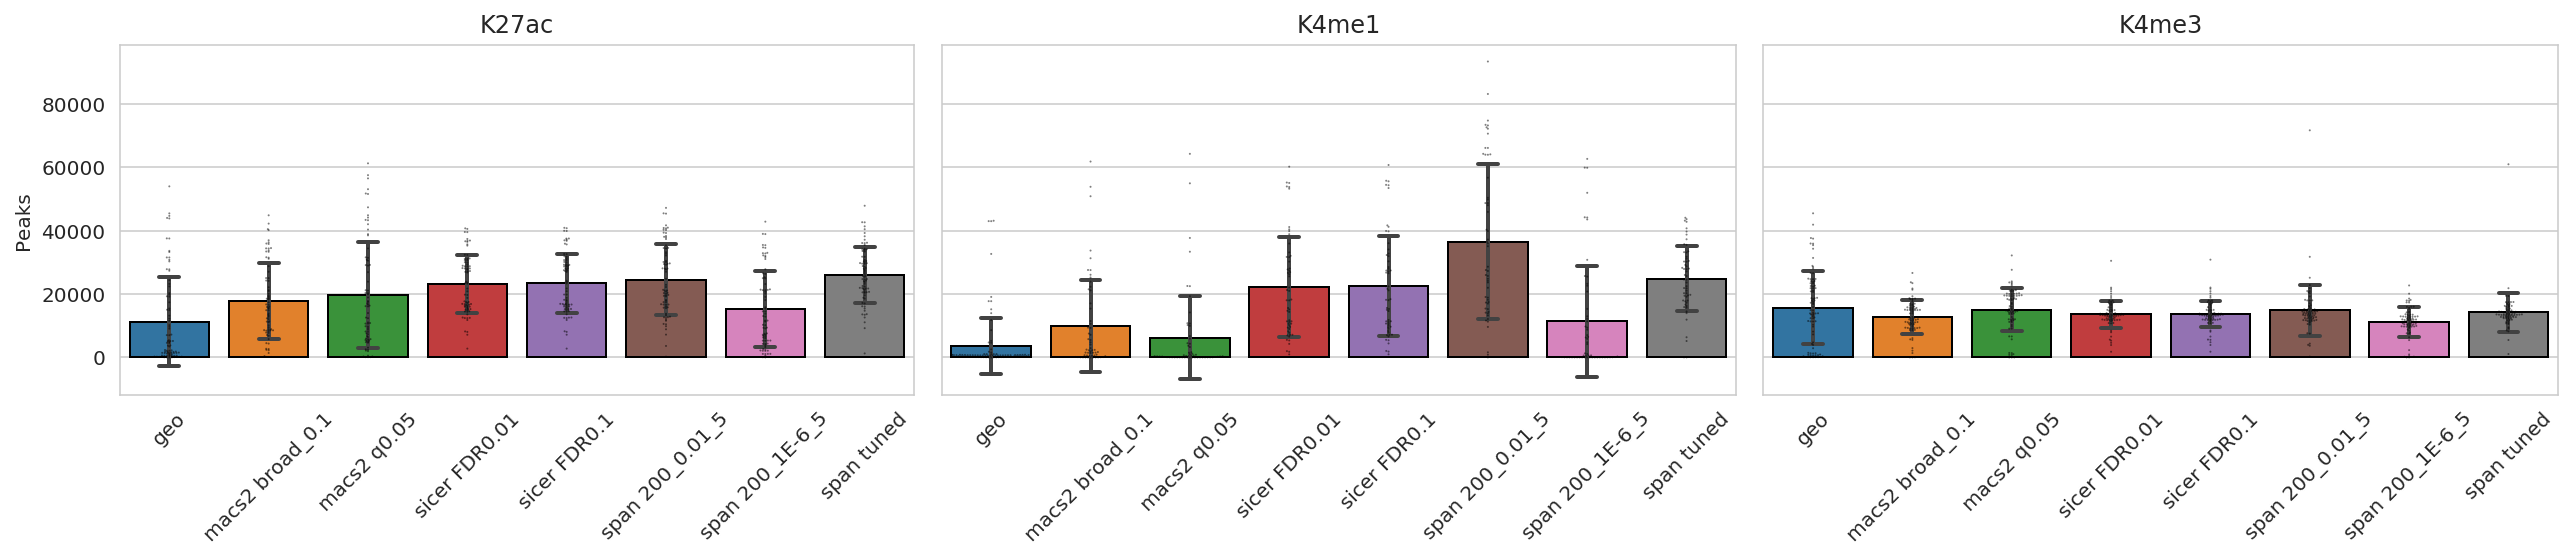

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


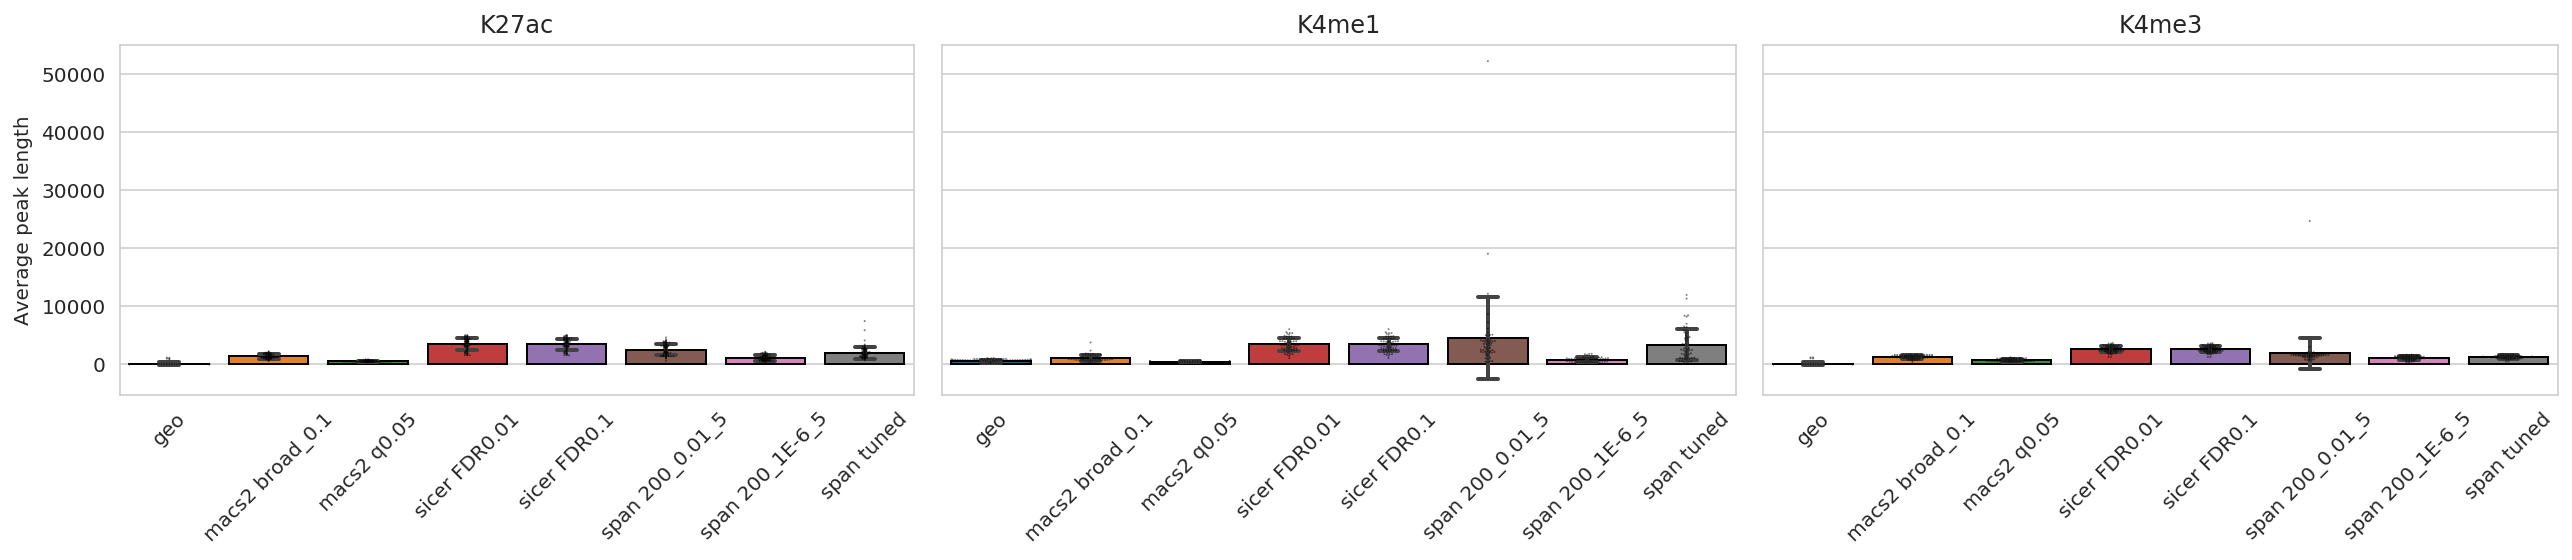

In [27]:
plot_data_cells(dfa, 'level', 'peaks', 'Peaks')
plt.show()
plot_data_cells(dfa, 'level', 'avg_length', 'Average peak length')
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


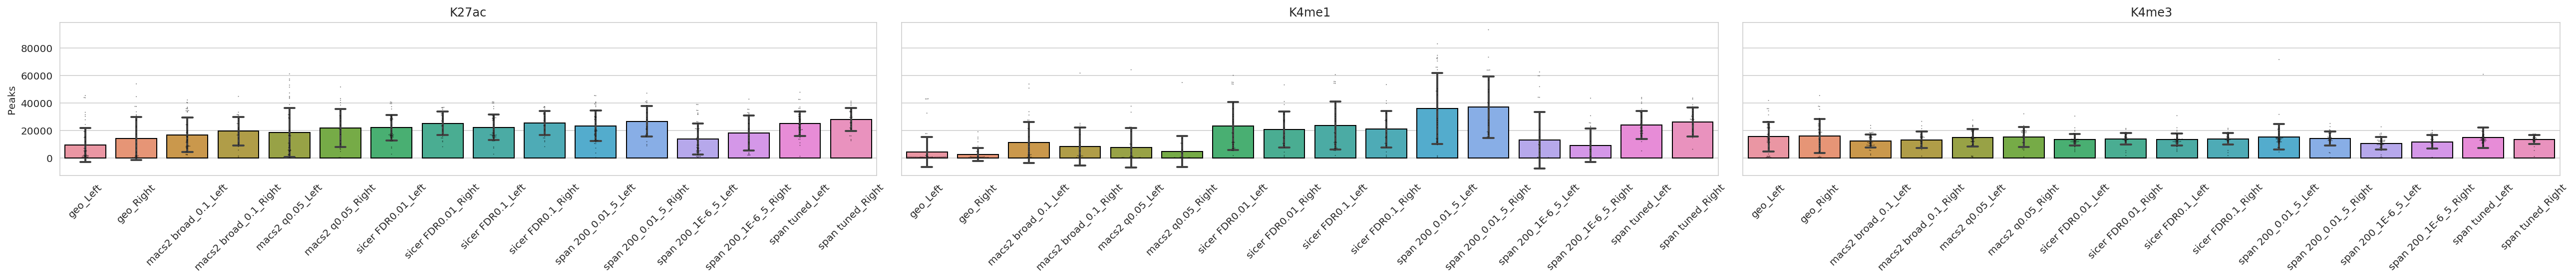

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


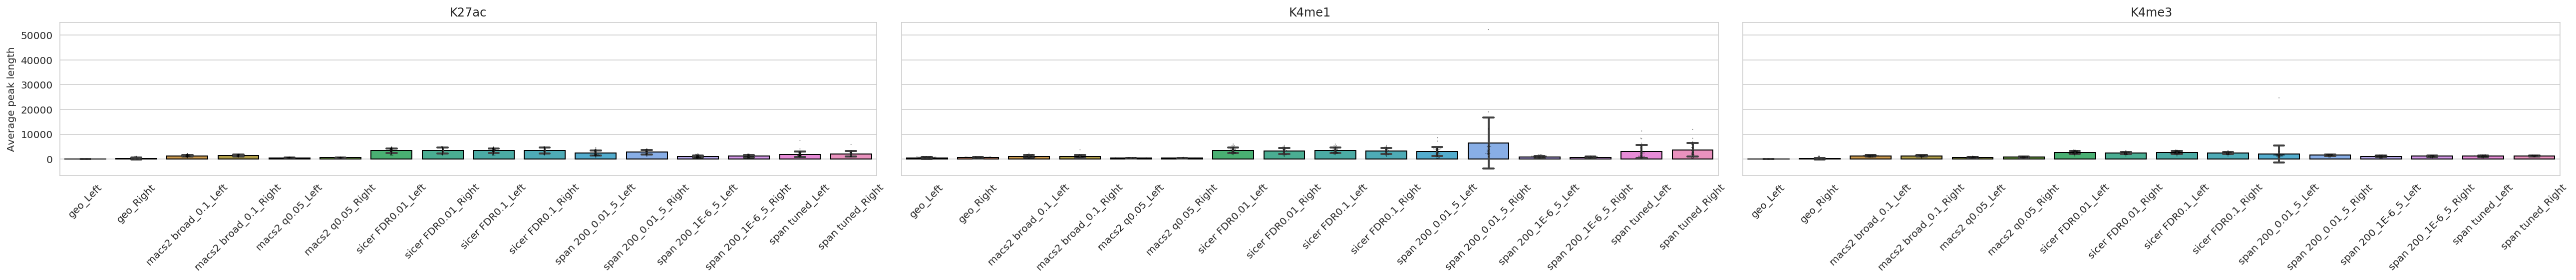

In [28]:
dfa['ld'] = dfa['level'] + '_' + dfa['direction']
plot_data_cells(dfa, 'ld', 'peaks', 'Peaks')
plt.show()
plot_data_cells(dfa, 'ld', 'avg_length', 'Average peak length')
plt.show()

# Overlap

In [27]:
def compute_overlap(df):
    # Compute overlaps
    dft = pd.DataFrame(columns=['id', 'modification', 'level', 'overlap'])
    levels = sorted(set(df['level']))
    for m in ['K27ac', 'K4me1', 'K4me3']:
        for l in levels:
            paths = [Path(f) for f in df.loc[np.logical_and(df['modification']==m, df['level']==l)]['file']]
            df_path = f'/tmp/overlap_{m}_{l}.tsv'
            mt = bm.load_or_build_metrics_table(paths, paths, Path(df_path),
                                                jaccard=False,
                                                threads=30)
            for row in mt.index:
                for col in mt.columns:
                    overlap = mt.loc[row][col]
                    dft.loc[len(dft)] = (f'{row}@{col}', m, l, overlap)
    return dft

[Skipped]: Already exists /tmp/overlap_K27ac_geo.tsv
[Skipped]: Already exists /tmp/overlap_K27ac_macs2 broad_0.1.tsv
[Skipped]: Already exists /tmp/overlap_K27ac_macs2 q0.05.tsv
[Skipped]: Already exists /tmp/overlap_K27ac_sicer FDR0.01.tsv
[Skipped]: Already exists /tmp/overlap_K27ac_sicer FDR0.1.tsv
[Skipped]: Already exists /tmp/overlap_K27ac_span 200_1E-6_5.tsv
[Skipped]: Already exists /tmp/overlap_K27ac_span tuned.tsv
[Skipped]: Already exists /tmp/overlap_K4me1_geo.tsv
[Skipped]: Already exists /tmp/overlap_K4me1_macs2 broad_0.1.tsv
[Skipped]: Already exists /tmp/overlap_K4me1_macs2 q0.05.tsv
[Skipped]: Already exists /tmp/overlap_K4me1_sicer FDR0.01.tsv
[Skipped]: Already exists /tmp/overlap_K4me1_sicer FDR0.1.tsv
[Skipped]: Already exists /tmp/overlap_K4me1_span 200_1E-6_5.tsv
[Skipped]: Already exists /tmp/overlap_K4me1_span tuned.tsv
[Skipped]: Already exists /tmp/overlap_K4me3_geo.tsv
[Skipped]: Already exists /tmp/overlap_K4me3_macs2 broad_0.1.tsv
[Skipped]: Already exist

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


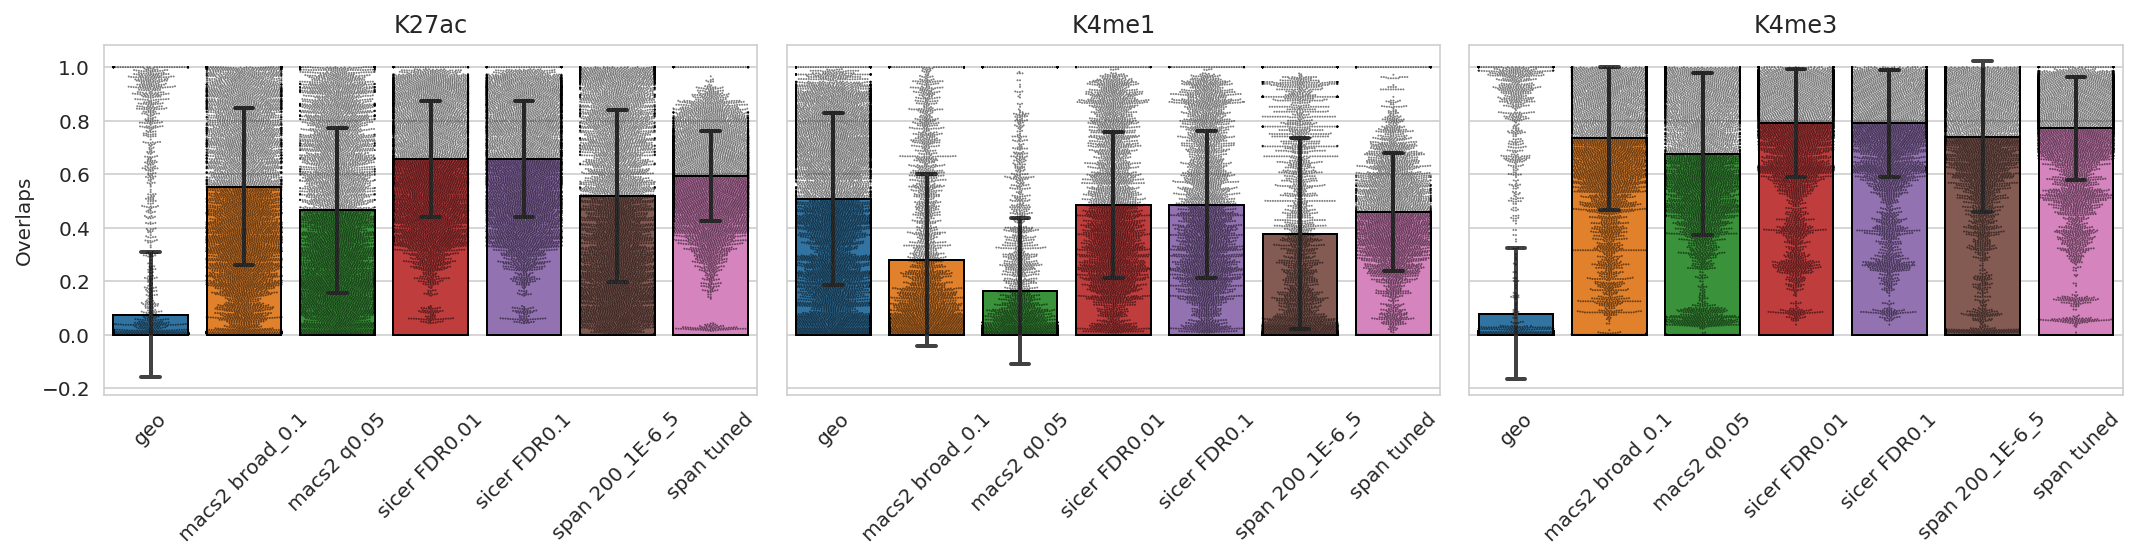

In [114]:
df_overlap = compute_overlap(dfa)
plot_data_cells(df_overlap, 'level', 'overlap', 'Overlaps')

# Peaks number vs library size

In [29]:
library_sizes = pd.read_csv(
    '/mnt/stripe/shpynov/2020_GSE104284_replicated_k27ac_k4me1_k4me3/samples-filtered.tsv', sep='\t'
)
library_sizes

Sample Name Error rate  M Non-Primary  \
0    GSM2794024_3h_03_Right_A_K4me3_C36PAACXX.8      0.35%            0.0   
1    GSM2794025_3h_03_Right_B_K27ac_C36PAACXX.8      0.13%            0.0   
2    GSM2794026_3h_03_Right_B_K4me1_C36PAACXX.8      0.12%            0.0   
3       GSM2794027_3h_03_Left_K27ac_C36PAACXX.7      0.13%            0.0   
4       GSM2794028_3h_03_Left_K4me1_C36PAACXX.7      0.12%            0.0   
..                                          ...        ...            ...   
307   GSM2794332_C4KGFACXX.6.28d_05_Right_K4me1      0.26%            0.0   
308   GSM2794333_C4KGFACXX.6.28d_05_Right_K4me3      0.31%            0.0   
309    GSM2794334_C4KGFACXX.6.28d_05_Left_K27ac      0.27%            0.0   
310    GSM2794335_C4KGFACXX.6.28d_05_Left_K4me1      0.29%            0.0   
311    GSM2794336_C4KGFACXX.6.28d_05_Left_K4me3      0.24%            0.0   

     M Reads Mapped % Mapped  M Total seqs  
0               5.2   100.0%           5.2  
1               0.3   100.0%           0.3  
2               4.4   100.0%           4.4  
3              18.5   100.0%          18.5  
4              12.0   100.0%          12.0  
..              ...      ...           ...  
307             7.2   100.0%           7.2  
308             8.0   100.0%           8.0  
309            19.0   100.0%          19.0  
310            45.5   100.0%          45.5  
311            27.4   100.0%          27.4  

[312 rows x 6 columns]

In [30]:
mseqs = np.zeros(len(dfa))
for i, gsm in enumerate(tqdm(dfa['gsm'])):
    value = library_sizes.loc[[gsm in sn for sn in library_sizes['Sample Name']]]['M Total seqs']
    if len(value) == 0:
        print(f'Nothing found for {gsm}')
        value = 0
    mseqs[i] = value

Nothing found for GSM2794125



In [31]:
t = dfa[['level', 'peaks', 'modification']].copy()
t['mseqs'] = mseqs
t = t.loc[t['level'].isin(['span tuned', 'macs2 broad_0.1', 'sicer FDR0.01'])]
t

level  peaks modification  mseqs
0    macs2 broad_0.1  11488        K4me1   28.7
1    macs2 broad_0.1  18543        K4me3   33.4
2    macs2 broad_0.1    635        K4me1   29.2
3    macs2 broad_0.1  15672        K27ac   23.6
4    macs2 broad_0.1   7156        K4me1   29.5
..               ...    ...          ...    ...
409       span tuned  13418        K4me3   27.4
410       span tuned  10978        K4me3   16.7
411       span tuned  13725        K4me3    3.0
412       span tuned  16277        K4me3   20.6
413       span tuned  12894        K4me3    5.2

[621 rows x 4 columns]

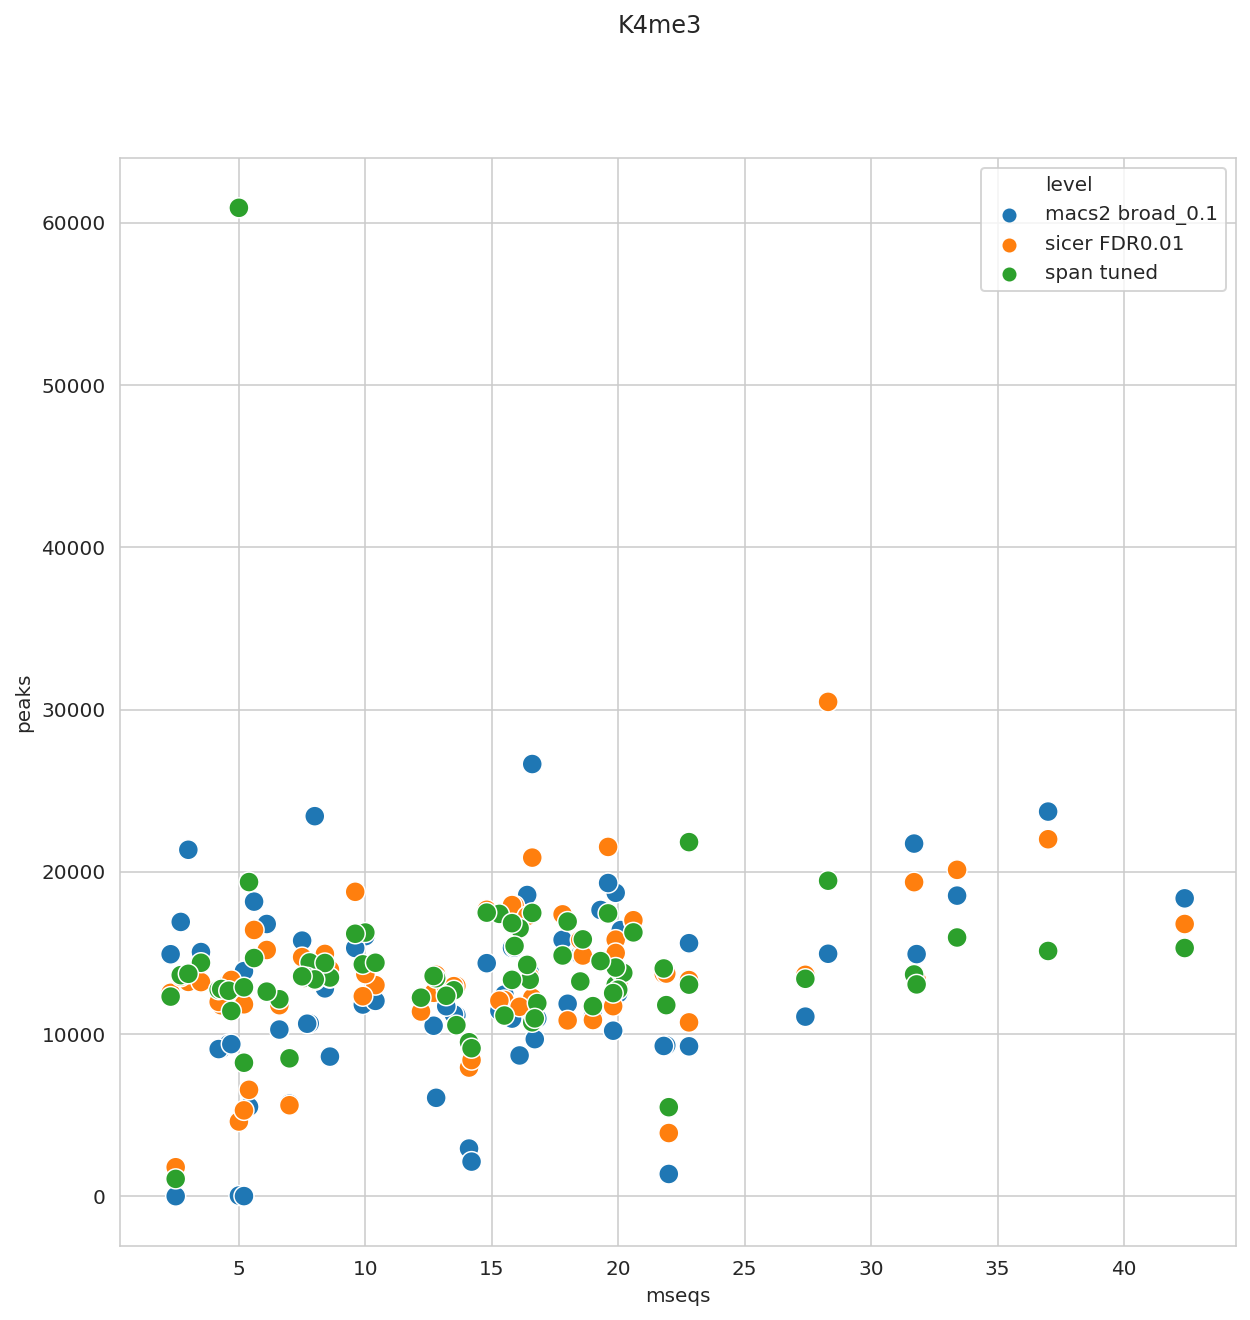

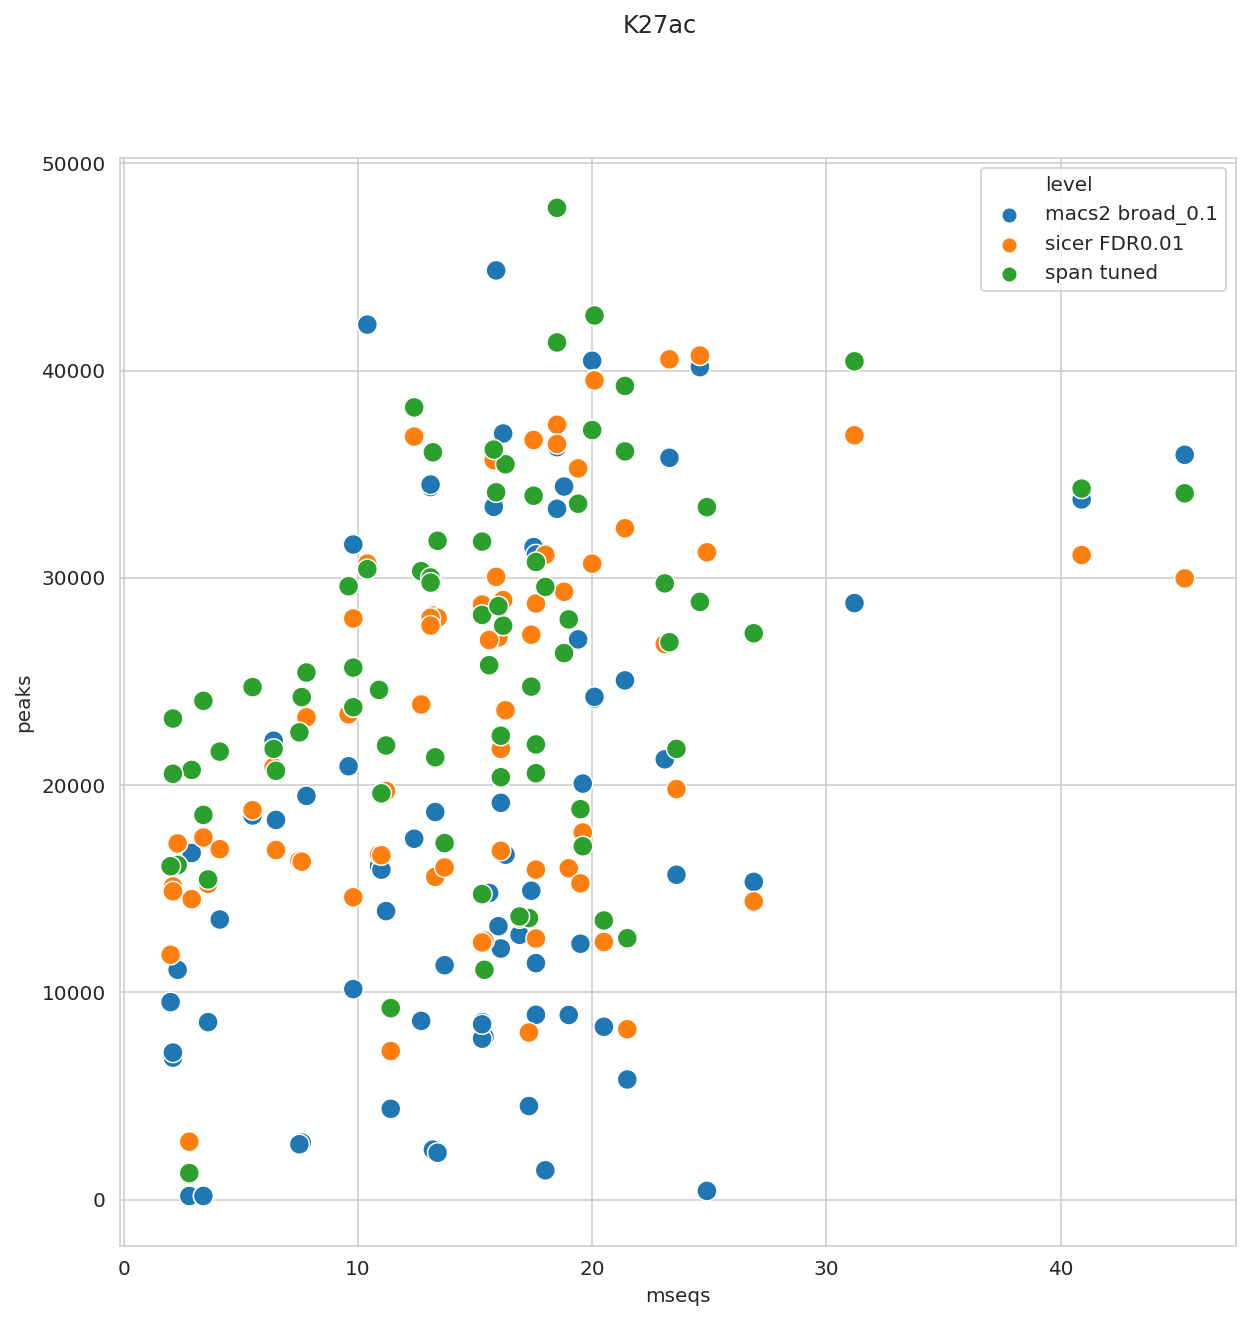

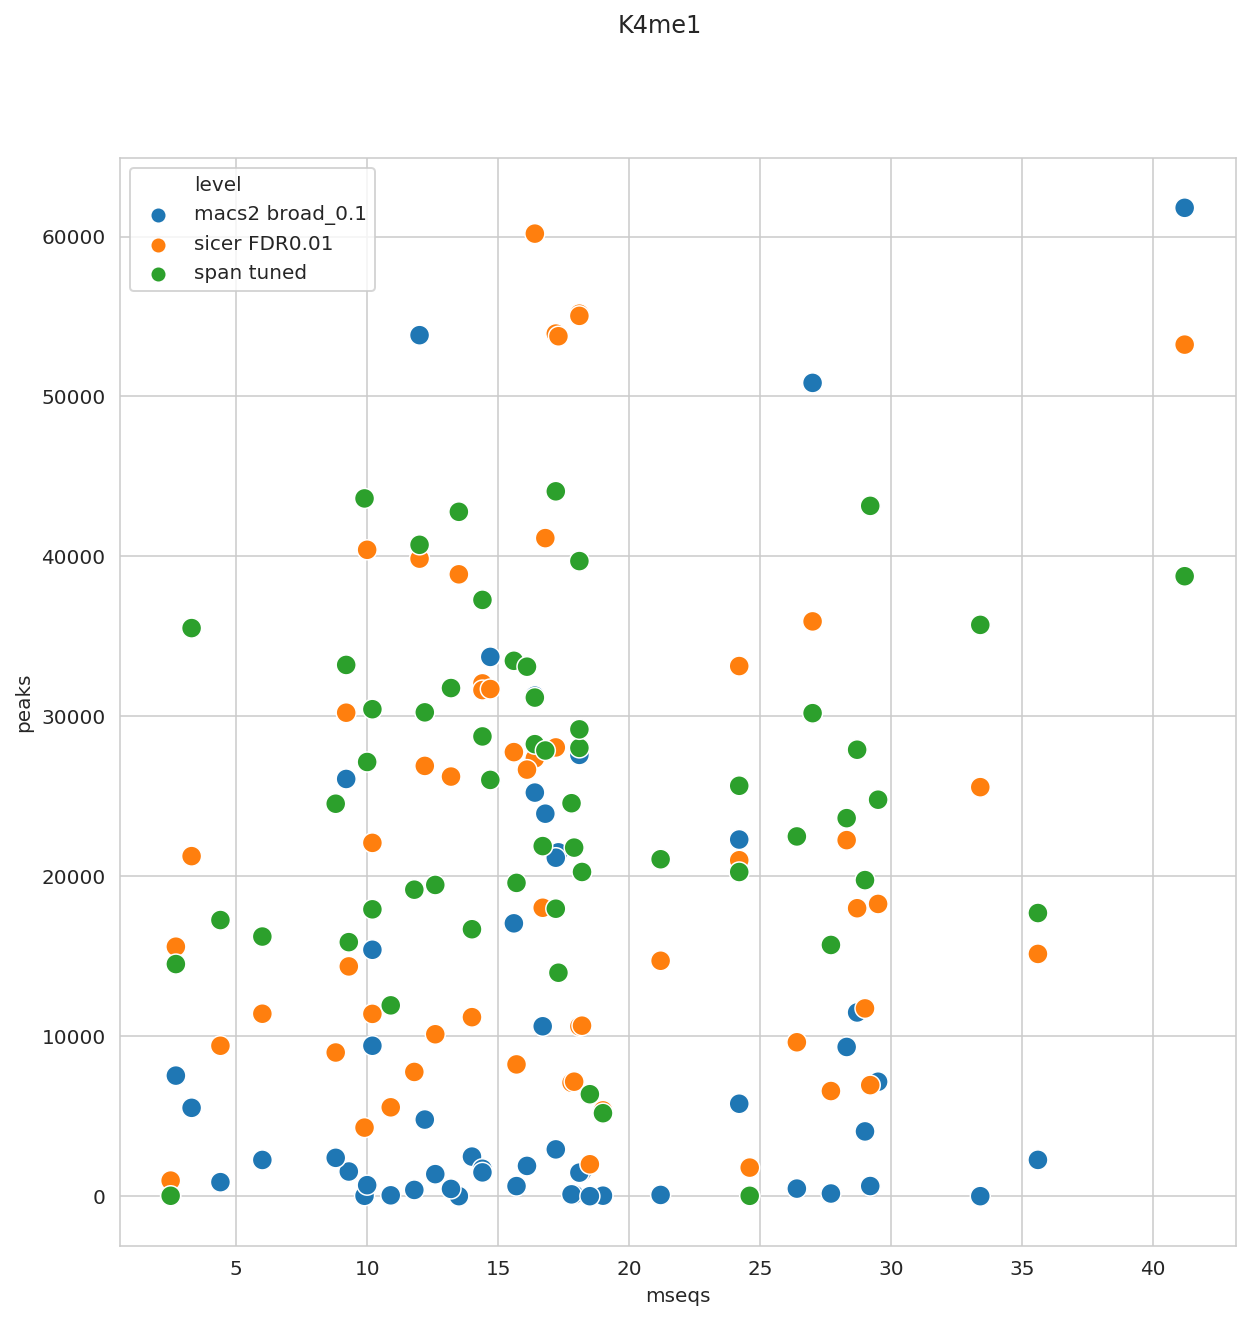

In [32]:
for m in set(t['modification']):
    plt.figure(figsize=(10, 10))
    sns.scatterplot(x='mseqs', y='peaks', hue='level', data=t.loc[t['modification'] == m], s=100)
    plt.suptitle(m)
    plt.show()

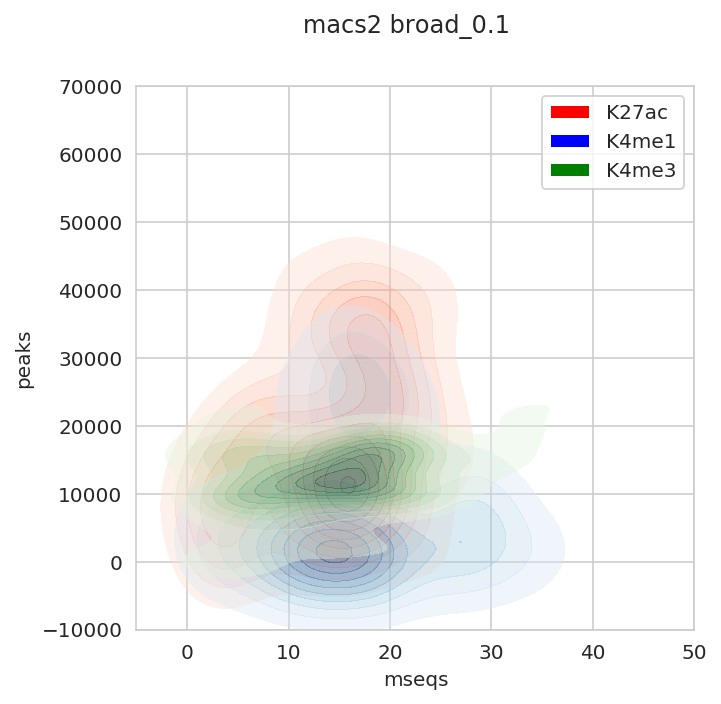

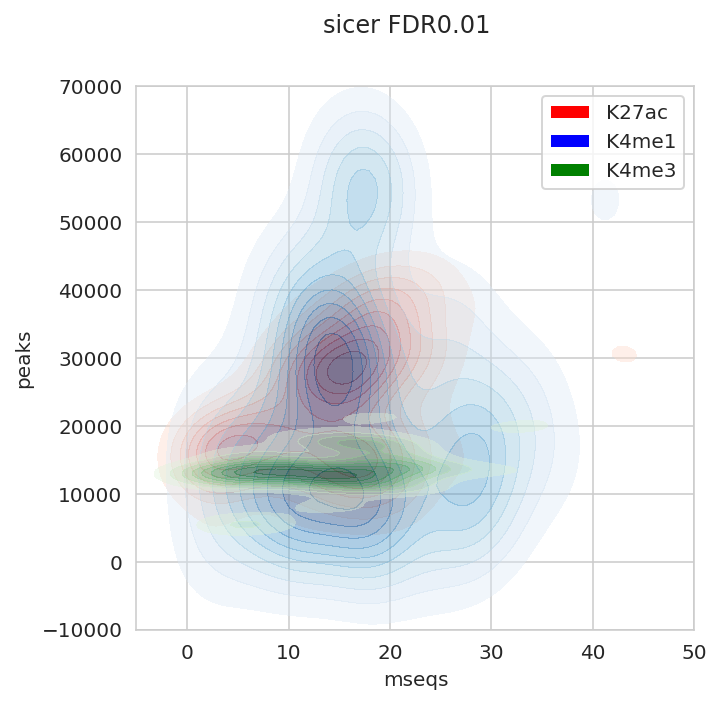

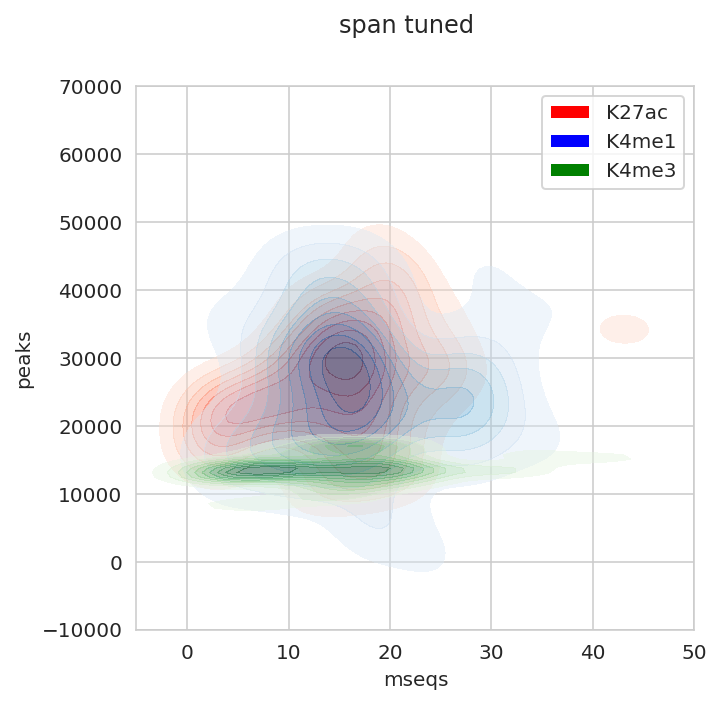

In [33]:
from matplotlib.patches import Patch

cmaps = ['Reds', 'Blues', 'Greens']
legend_elements = [Patch(facecolor=c[:-1], label=m) 
                   for c, m in zip(cmaps, sorted(set(t['modification'])))]
for l in sorted(set(t['level'])):
    plt.figure(figsize=(5, 5))
    tl = t.loc[t['level']==l]
    for i, m in enumerate(sorted(set(tl['modification']))):
        tlm = tl.loc[tl['modification']==m]
        sns.kdeplot(tlm['mseqs'], tlm['peaks'], cmap=cmaps[i], shade=True, shade_lowest=False, alpha=0.4)
    axes = plt.gca()
    axes.set_xlim([-5 ,50])
    axes.set_ylim([-10000, 70000])
    plt.suptitle(l)
    plt.legend(handles=legend_elements)
    plt.show()

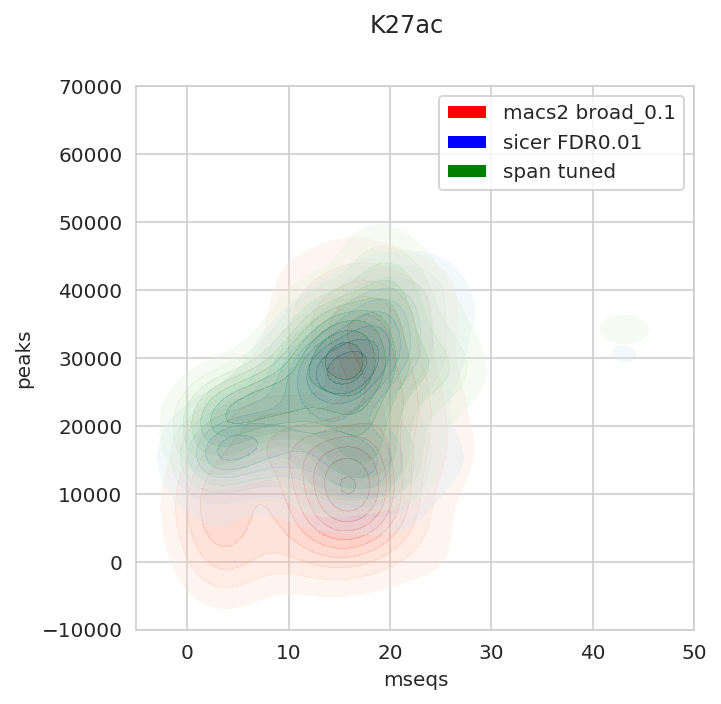

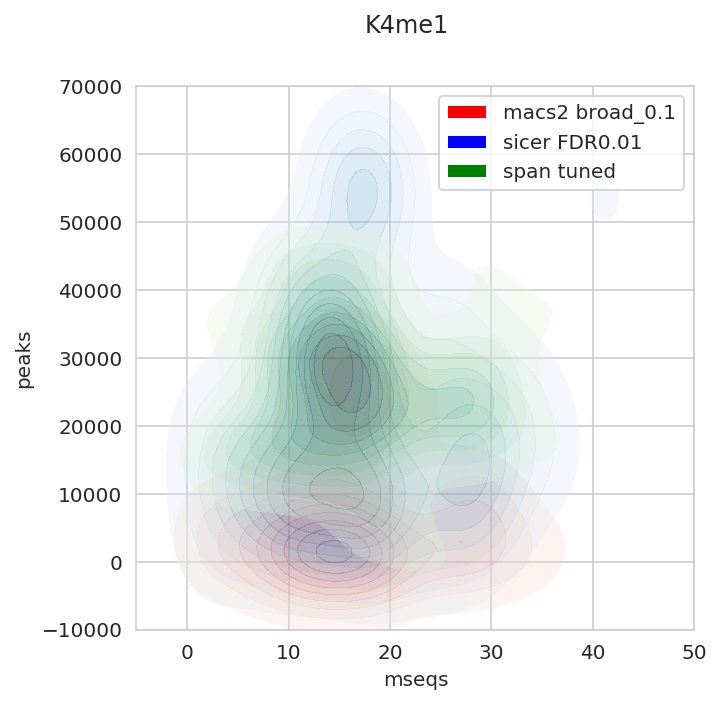

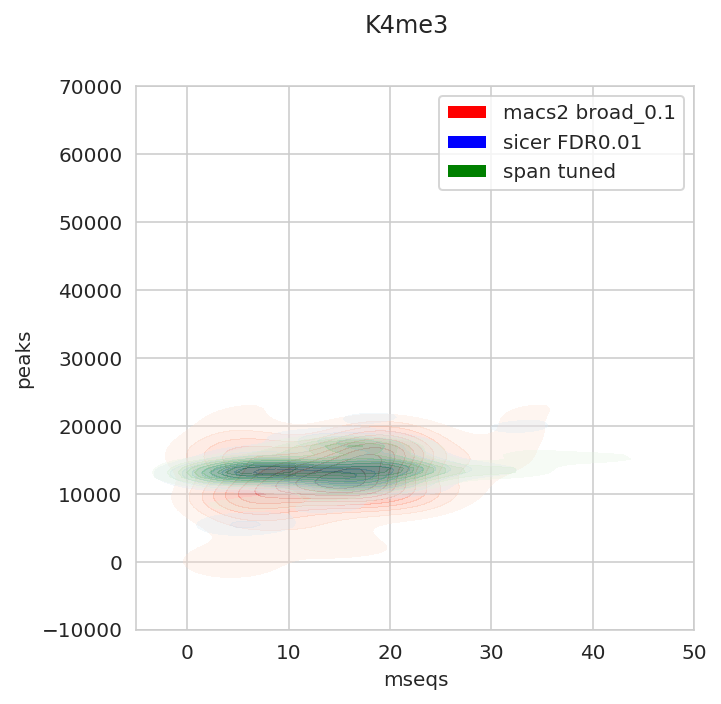

In [34]:
cmaps = ['Reds', 'Blues', 'Greens']
legend_elements = [Patch(facecolor=c[:-1], label=l) 
                   for c, l in zip(cmaps, sorted(set(t['level'])))]
for m in sorted(set(t['modification'])):
    plt.figure(figsize=(5, 5))
    tm = t.loc[t['modification']==m]
    for i, l in enumerate(sorted(set(tm['level']))):
        tml = tm.loc[tm['level']==l]
        sns.kdeplot(tml['mseqs'], tml['peaks'], cmap=cmaps[i], shade=True, shade_lowest=False, alpha=0.3)
    axes = plt.gca()
    axes.set_xlim([-5 ,50])
    axes.set_ylim([-10000, 70000])
    plt.suptitle(m)
    plt.legend(handles=legend_elements)
    plt.show()